In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets,transforms
from torch.autograd import Variable # Variable class is deprecated
import matplotlib.pyplot as plt
import os

%matplotlib inline

In [2]:
is_cuda=False
if torch.cuda.is_available():
    is_cuda = True
    
# setup variable device to store cuda property
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
# download datasetes if data directory doesn't exist
download = not os.path.exists("data")

In [4]:
transformation = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])

train_dataset = datasets.MNIST('data/', train=True, transform=transformation, download=download)
test_dataset = datasets.MNIST('data/', train=False, transform=transformation, download=download)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

In [5]:
sample_data = next(iter(train_loader))

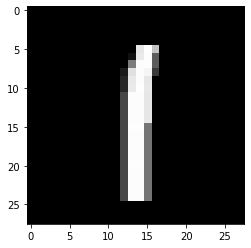

In [6]:
# data image
plt.imshow(sample_data[0][2].numpy()[0], cmap="gray");

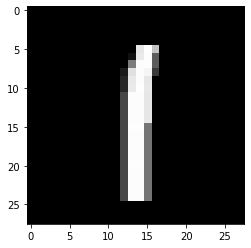

In [7]:
# Caution: the function is neither normalization or reverse operation
# normalization function: z = (x - \mu) / s
def plot_img(image):
    image = image.numpy()[0]
    mean = 0.1307
    std = 0.3081
    image = ((mean * image) + std)
    plt.imshow(image,cmap='gray')

plot_img(sample_data[0][2])

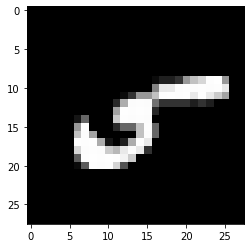

In [8]:
plot_img(sample_data[0][1])

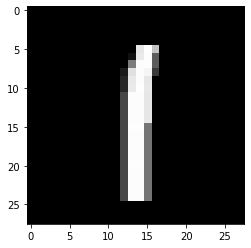

In [9]:
# reverse the normalization tranform
def reverse_transform(image, mean=0.1307, std=0.3081):
    image = image.numpy() * std + mean
    plt.imshow(image[0], cmap="gray")
    
reverse_transform(sample_data[0][2])

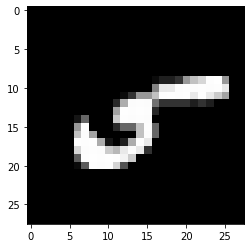

In [10]:
reverse_transform(sample_data[0][1])

### Single Convolution Blog
通过使用单个卷积 block 对单个图片的处理过程了，解卷积网络中 Conv 的使用过程。需要<font color='red'>注意卷积层的 weight 和 bias 是初始值是通过均匀分布获取</font>——均匀分布模式为：

$$
\mu(\sqrt{k}, \sqrt{k}) \\
k = \frac{1}{C_{in} \times \displaystyle{\prod_{i=0}^m kernel\_size}}
$$

m 值与使用的卷积维度相关，一维卷积的值为 0，二维（[Conv2d](https://pytorch.org/docs/stable/nn.html#conv2d)）为 1 以此类推。如果需要对 weight 和 bias 的数据进行调整，可以使用 [apply](https://pytorch.org/docs/master/nn.html#torch.nn.Module.apply) 方法对参数权重进行调整。

卷积层的计算过程是矩阵乘法计算的过程，在 [Image Kernels explained visually](http://setosa.io/ev/image-kernels/) 中进行了可视化表述卷积计算过程

In [11]:
conv2d_1 = nn.Conv2d(1, 10, kernel_size=5)
conv2d_2 = nn.Conv2d(10, 20, kernel_size=5)
conv2d_1.weight

Parameter containing:
tensor([[[[ 0.1928, -0.0438,  0.0465, -0.1405,  0.1004],
          [-0.0039, -0.0433, -0.1418,  0.0236,  0.0644],
          [ 0.0657,  0.0546, -0.0626, -0.0225,  0.0460],
          [-0.0056,  0.0595,  0.1033, -0.1560, -0.0112],
          [-0.0030, -0.1698, -0.1003, -0.0157,  0.1521]]],


        [[[ 0.1608,  0.1660, -0.0437, -0.0341,  0.0520],
          [ 0.0862,  0.1838,  0.1472,  0.1936, -0.1372],
          [ 0.1632, -0.0189, -0.1289, -0.0216, -0.0910],
          [ 0.1267,  0.1526,  0.0584,  0.1249,  0.0791],
          [-0.0957, -0.1171,  0.1932, -0.1731,  0.1969]]],


        [[[-0.1232,  0.0888, -0.1243, -0.0881, -0.0083],
          [-0.0025,  0.1644, -0.0385,  0.1604,  0.1087],
          [ 0.0683,  0.1627, -0.1884, -0.0085,  0.0610],
          [ 0.0658, -0.0175,  0.0990, -0.1725, -0.1851],
          [ 0.0871,  0.1892,  0.1649,  0.0235,  0.1412]]],


        [[[ 0.0031, -0.1224, -0.0665,  0.1923,  0.0461],
          [ 0.1352,  0.0353, -0.1029,  0.0318, -0.1944

In [12]:
# 需要调整数据维度——图片数量 * 图像通道数 * 图像宽度 * 图像高度
test_data = sample_data[0][1]
test_data.resize_(1, *test_data.shape)
conv_sample = conv2d_1(test_data)
conv_sample

tensor([[[[-0.1688, -0.1688, -0.1688,  ..., -0.1688, -0.1688, -0.1688],
          [-0.1688, -0.1688, -0.1688,  ..., -0.1688, -0.1688, -0.1688],
          [-0.1688, -0.1688, -0.1688,  ..., -0.1688, -0.1688, -0.1688],
          ...,
          [-0.1688, -0.1688, -0.1688,  ..., -0.1688, -0.1688, -0.1688],
          [-0.1688, -0.1688, -0.1688,  ..., -0.1688, -0.1688, -0.1688],
          [-0.1688, -0.1688, -0.1688,  ..., -0.1688, -0.1688, -0.1688]],

         [[-0.4392, -0.4392, -0.4392,  ..., -0.4392, -0.4392, -0.4392],
          [-0.4392, -0.4392, -0.4392,  ..., -0.4392, -0.4392, -0.4392],
          [-0.4392, -0.4392, -0.4392,  ..., -0.4392, -0.4392, -0.4392],
          ...,
          [-0.4392, -0.4392, -0.4392,  ..., -0.4392, -0.4392, -0.4392],
          [-0.4392, -0.4392, -0.4392,  ..., -0.4392, -0.4392, -0.4392],
          [-0.4392, -0.4392, -0.4392,  ..., -0.4392, -0.4392, -0.4392]],

         [[-0.2936, -0.2936, -0.2936,  ..., -0.2936, -0.2936, -0.2936],
          [-0.2936, -0.2936, -

池化层通常使用 MaxPooling 和 AveragePooling，但可选方法具有多种。池化计算中并没有权重的计算，因此在反馈计算中它并不需要进行权重更新

In [13]:
pool_sample = F.max_pool2d(conv_sample, 2)

In [14]:
print(
    f"Origin data dimentions: {test_data.shape}"
    f"\nFirst convolution layers dimentions: {conv_sample.shape} with weight dimentions: {conv2d_1.weight.shape}"
    f"\nPooling layers dimentions: {pool_sample.shape} with filter dimentions: (2, 2)"
    f"\nSecond convolution layers dimentions: {conv2d_2(pool_sample).shape} with weight dimentions: {conv2d_2.weight.shape}"
    f"\nLast layer dimentions: {F.max_pool2d(conv2d_2(pool_sample), 2).shape}"
)

Origin data dimentions: torch.Size([1, 1, 28, 28])
First convolution layers dimentions: torch.Size([1, 10, 24, 24]) with weight dimentions: torch.Size([10, 1, 5, 5])
Pooling layers dimentions: torch.Size([1, 10, 12, 12]) with filter dimentions: (2, 2)
Second convolution layers dimentions: torch.Size([1, 20, 8, 8]) with weight dimentions: torch.Size([20, 10, 5, 5])
Last layer dimentions: torch.Size([1, 20, 4, 4])


In [15]:
F.max_pool2d(conv2d_2(pool_sample), 2).view(1, -1).shape

torch.Size([1, 320])

通过卷积层之后，需要处理进行 Flatten 之后才能作为全连接层的输入。

In [16]:
fc1 = F.linear(
    F.max_pool2d(
        conv2d_2(pool_sample),
        2).view(-1, 320), # flatten 处理卷积层结果
    torch.randn(50, 320)
    )
fc2 = F.linear(F.relu(fc1), torch.randn(10, 50))
out = F.log_softmax(fc2, dim=1)

In [17]:
out

tensor([[-7.2053e+01, -9.0526e+01, -2.0884e+01, -1.5955e+01, -2.8109e+00,
         -1.1843e+02, -5.4338e+01, -5.6213e+01, -6.2038e-02, -2.6373e+01]],
       grad_fn=<LogSoftmaxBackward>)

In [18]:
# 已经使用 log_softmax 处理数据，需要通过 nll_loss 计算损失值
F.nll_loss(out, sample_data[1][1].reshape((1, )))

tensor(118.4317, grad_fn=<NllLossBackward>)

In [19]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320) # Maybe better common description x = x.view(1, -1)
        x = F.relu(self.fc1(x))
        #x = F.dropout(x,p=0.1, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x,dim=1)

In [20]:
model = Net()

# if is_cuda:
#     model.cuda()
# former code is worst
model = model.to(device)

In [21]:
optimizer = optim.SGD(model.parameters(),lr=0.01)

In [22]:
data , target = next(iter(train_loader))

In [23]:
# output = model(Variable(data.cuda())) 
output = model(Variable(data.to(device))) # better way

In [24]:
output.size()

torch.Size([32, 10])

In [25]:
target.size()

torch.Size([32])

In [29]:
def fit(epoch,model,data_loader,phase='training',volatile=False):
    if phase == 'training':
        model.train()
    if phase == 'validation':
        model.eval()
        volatile=True
    running_loss = 0.0
    running_correct = 0
    for batch_idx , (data,target) in enumerate(data_loader):
        # if is_cuda:
        #    data,target = data.cuda(),target.cuda()
        data, target = data.to(device), target.to(device)
        # Varibale is deprecated
        # data , target = Variable(data,volatile),Variable(target) 
        if phase == 'training':
            optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output,target)
        
        running_loss += F.nll_loss(output,target,size_average=False).item()
        preds = output.data.max(dim=1,keepdim=True)[1]
        running_correct += preds.eq(target.data.view_as(preds)).cpu().sum()
        if phase == 'training':
            loss.backward()
            optimizer.step()
    
    loss = running_loss/len(data_loader.dataset)
    accuracy = 100. * running_correct/len(data_loader.dataset)
    
    print(f'{phase} loss is {loss:{5}.{2}} and {phase} accuracy is {running_correct}/{len(data_loader.dataset)}{accuracy:{10}.{4}}')
    return loss,accuracy

In [30]:
train_losses , train_accuracy = [],[]
val_losses , val_accuracy = [],[]
for epoch in range(1,20):
    epoch_loss, epoch_accuracy = fit(epoch,model,train_loader,phase='training')
    val_epoch_loss , val_epoch_accuracy = fit(epoch,model,test_loader,phase='validation')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

training loss is  0.72 and training accuracy is 46232/60000     77.05
validation loss is  0.18 and validation accuracy is 9408/10000     94.08
training loss is   0.2 and training accuracy is 56512/60000     94.19
validation loss is 0.095 and validation accuracy is 9706/10000     97.06
training loss is  0.15 and training accuracy is 57353/60000     95.59
validation loss is 0.073 and validation accuracy is 9774/10000     97.74
training loss is  0.13 and training accuracy is 57701/60000     96.17
validation loss is 0.062 and validation accuracy is 9799/10000     97.99
training loss is  0.11 and training accuracy is 58006/60000     96.68
validation loss is  0.06 and validation accuracy is 9816/10000     98.16
training loss is   0.1 and training accuracy is 58143/60000      96.9
validation loss is 0.047 and validation accuracy is 9838/10000     98.38
training loss is 0.095 and training accuracy is 58327/60000     97.21
validation loss is 0.042 and validation accuracy is 9861/10000     98.61

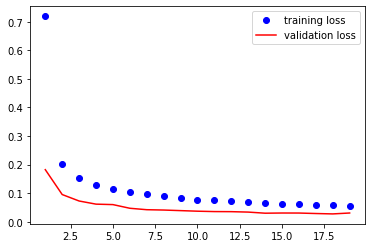

In [31]:
plt.plot(range(1,len(train_losses)+1),train_losses,'bo',label = 'training loss')
plt.plot(range(1,len(val_losses)+1),val_losses,'r',label = 'validation loss')
plt.legend();

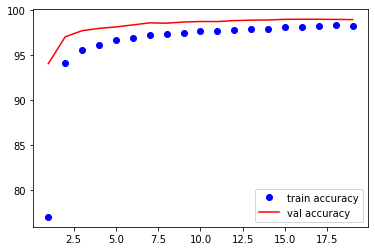

In [32]:
plt.plot(range(1,len(train_accuracy)+1),train_accuracy,'bo',label = 'train accuracy')
plt.plot(range(1,len(val_accuracy)+1),val_accuracy,'r',label = 'val accuracy')
plt.legend();

## Understanding 1d convolutions

In [33]:
conv = nn.Conv1d(1,1,3,bias=False)

In [34]:
conv.weight

Parameter containing:
tensor([[[-0.5291, -0.3016, -0.2987]]], requires_grad=True)

In [35]:
sample = torch.randn(1,1,7)

In [36]:
sample

tensor([[[ 2.2448, -0.5942, -0.5692,  0.5850, -0.1082, -0.2091, -0.1070]]])

In [37]:
conv(Variable(sample))

tensor([[[-0.8384,  0.3113,  0.1570, -0.2144,  0.1523]]],
       grad_fn=<SqueezeBackward1>)

### Understand how padding works in Conv1d

In [38]:
conv = nn.Conv1d(1,1,3,padding=2,bias=False)
conv.weight

Parameter containing:
tensor([[[ 0.0837, -0.1751, -0.4306]]], requires_grad=True)

In [39]:
sample = torch.randn(1,1,7)
sample

tensor([[[-0.1973, -0.1720,  1.1594,  0.0947,  0.1548, -0.4772, -0.7744]]])

In [40]:
conv(Variable(sample))

tensor([[[ 0.0850,  0.1086, -0.4856, -0.2582,  0.0138,  0.1863,  0.4299,
           0.0956, -0.0648]]], grad_fn=<SqueezeBackward1>)

## 参考
1. [Weight Initialization in Neural Networks](https://towardsdatascience.com/weight-initialization-in-neural-networks-a-journey-from-the-basics-to-kaiming-954fb9b47c79)

    讲述权重初始化的几种方法以及为什么建议初始化过程使用非标准化权重更新的原因

2. [基于卷积神经网络的面部表情识别(Pytorch实现)----台大李宏毅机器学习作业](https://www.cnblogs.com/HL-space/p/10888556.html)

    构建了 CNN 的 Block 以及权重初始化调整的示例
    
3. [Pooling layers — PyTorch documentation](https://pytorch.org/docs/stable/nn.html#pooling-layers)

    Pytorch 提供了多种池化方法